# Complete code - Transient Dynamics and Propagation of Voltage Fluctuations

First two codes are used for obtaining the adjecency matrix, both for 1D case, as well as the Nigerian grid. 

# 1D - Adjecency matrix

In [ ]:
import numpy as np

k = 60 # Grid size

# Obtain the adjecency matrix
B = np.zeros((k,k))

i = 1
while i < (k-1):
    B[i,i+1] = B[i,i-1] = 1
    i = i + 1
    
B[0,1] = B[-1,-2] = 1

np.save("Test matrix", B)

# Nigerian grid - Adjecency matrix

In [ ]:
import numpy as np

# Import the neighbouring nodes
i, j = np.loadtxt("C:/Users/Fahrudin Delic/Desktop/nglines1.csv", skiprows=1 , unpack=True, delimiter=";")


# Obtain the adjecency matrix

A = np.zeros((int(np.max(np.concatenate([i,j]))),int(np.max(np.concatenate([i,j])))))

k = 0
while k < int(len(i)):
    i_pos = i.astype(int)[k] - 1
    j_pos = j.astype(int)[k] - 1
    A[i_pos, j_pos] = 1
    A[j_pos, i_pos] = 1
    k = k + 1
    

# Save the matrix 
B = np.save("C:/Users/Fahrudin Delic/Desktop/nglines_Adj_matrix.npy", A)

# 1D grid - Working simulation 

<ipython-input-1-db130cf97f20>:132: RuntimeWarning: invalid value encountered in double_scalars
  var_y_n = np.sum(var_coef * y[q,:])/np.sum(y[q,:])
<ipython-input-1-db130cf97f20>:135: RuntimeWarning: invalid value encountered in double_scalars
  var_yi_n = np.sum(var_coef * np.abs(yi[q,:]))/(np.sum(np.abs(yi[q,:])))
<ipython-input-1-db130cf97f20>:138: RuntimeWarning: invalid value encountered in double_scalars
  var_V_n = np.sum((var_coef * np.abs(V[q,:])))/(np.sum(np.abs(V[q,:])))


Execution time: 56.577104806900024


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


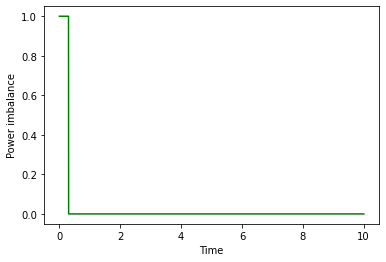

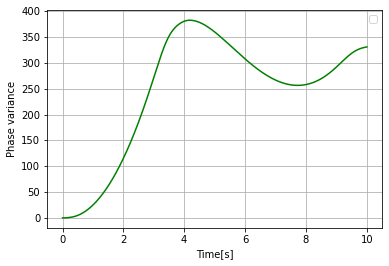

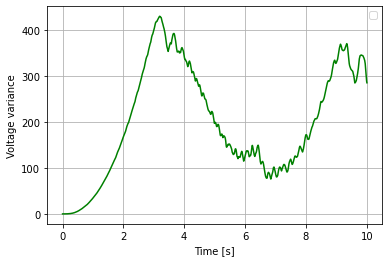

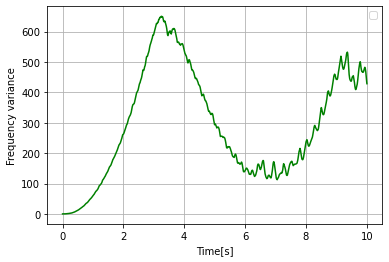

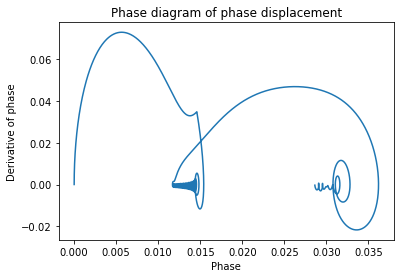

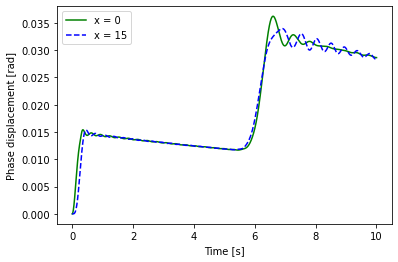

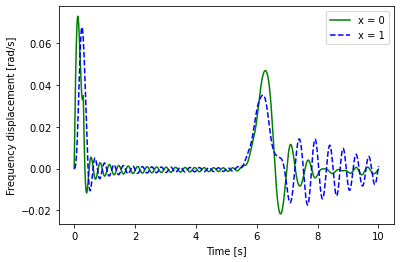

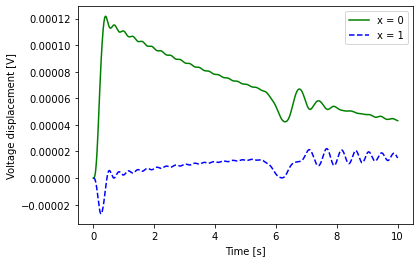

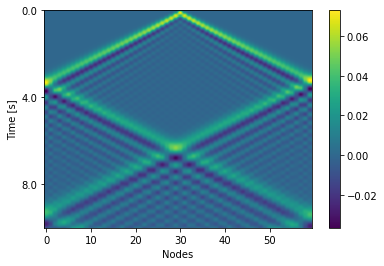

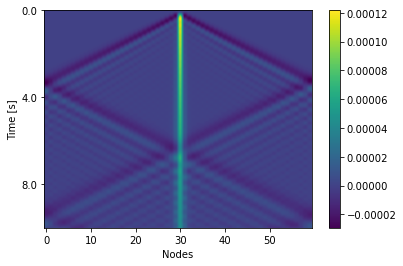

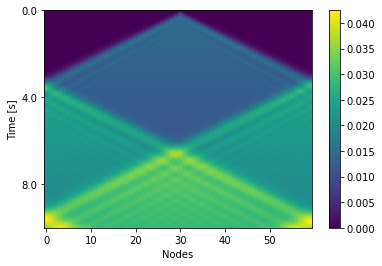

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import networkx as nx

def grid_var(Adj_matrix, x_P):
    G = nx.from_numpy_matrix(Adj_matrix)
    p = nx.shortest_path(G)
    g_dist = np.zeros(np.shape(Adj_matrix)[0])
    
    i = 0
    while i < (np.shape(Adj_matrix)[0]):
        j = 0
        while j < len(p[x_P][i]):
            g_dist[p[x_P][i][j]] = j
            j = j + 1
            
        i = i + 1
    return g_dist**2

########################
# Phase coefficients
H = 1 # Scaling coefficient (representing inertia like behaviour)

g1 = 0.1 # Damping coefficient
v1 = 100.5 # velocity squared

g = g1/H # Damping coefficient
v = v1/H # velocity squared

# Vo.ltage coefficients
T = 8.39
W = 0.34
F = 0.34

# Import the adjecency matrix 

#A = np.load(r"C:/Users/Fahrudin Delic/Desktop/nglines_Adj_matrix.npy")

A = np.load(r"C:/Users/Fahrudin Delic/Desktop/Test matrix.npy")

# Position of the initial power inbalance
x_P = 30

# Grid points
dx = 1

# Time steps
dt = 0.001
# Time iteratios
tmax = 10

# Dirac delta power for the ramp function
P0 = 1

t_ramp = 0.3 # End of ramp function
t0_ramp = 0 # Start of ramp function 

# Initial phase and first derivative of phase 
y00 = 0
yi00 = 0
V00 = 0
Vi00 = 0



#####################

# Calculate necessary constants

Dw = W/T # Diffusion constat
tau1 = 1/(g - 1/T + (2*W)/T) # tau prime

start = time.time()

# Create necessary arrays

# Create the spatial coordinates of Nigerian grid
x = np.linspace(0,int(np.shape(A)[0] - 1), int(np.shape(A)[0]))

# Phase RK coefficients
ay1 = 0 * x # k1, 1st component
ay2 = 0 * x # k1, 2nd component
by1 = 0 * x # k2, 1st component
by2 = 0 * x # k2, 2nd component of vector
cy1 = 0 * x # k3, 1st component
cy2 = 0 * x # k3, 2nd component
dy1 = 0 * x # k4, 1st component
dy2 = 0 * x # k4, 2nd component

# Voltage RK coefficients
av1 = 0 * x
bv1 = 0 * x 
cv1 = 0 * x
dv1 = 0 * x


y = np.zeros(((int(tmax/dt + 2)), int(np.shape(A)[0])))
yi = np.zeros(((int(tmax/dt + 2)),int(np.shape(A)[0])))
V = np.zeros(((int(tmax/dt + 2)), int(np.shape(A)[0])))
P0_array = np.zeros(((int(tmax/dt + 2)), int(np.shape(A)[0])))


# Initial conditions of y(if necessary)
y[0, x_P] = y00
yi[0, x_P] = yi00
V[0, x_P] = V00


# Initial condition of initial power disturbance

while t0_ramp < (t_ramp):
    P0_array[int(t0_ramp/dt), x_P] = P0
    t0_ramp = t0_ramp + dt

# Create necessary arrays for time, and spatial plottings 
t = 0
tarray = []
qarray = []
var_array_y = []
var_array_V = []
var_array_yi = []

var_coef = grid_var(A, x_P)

q = 0 # Counter of time steps
# Run the program until the tmax
while t <= tmax:
    tarray += [t]
    qarray += [q]
    # Variance of phase
    var_y_n = np.sum(var_coef * y[q,:])/np.sum(y[q,:])
    var_array_y += [float(var_y_n)] # Update phase varience array
    # Frequency variance
    var_yi_n = np.sum(var_coef * np.abs(yi[q,:]))/(np.sum(np.abs(yi[q,:])))
    var_array_yi += [float(var_yi_n)] # Update frequency varience array
    # Voltage variance
    var_V_n = np.sum((var_coef * np.abs(V[q,:])))/(np.sum(np.abs(V[q,:])))
    var_array_V += [float(var_V_n)] # Update voltage varience array
    i = 0
    while i < (len(x)):
        ay1[i] = dt * yi[q,i]
        ay2[i] = dt * (-g * yi[q, i] - v * (np.sum(A[i,:] * (y[q,i] - y[q,:]))) + P0_array[q, i] )
        av1[i] = (dt/T) * (-V[q, i] + W * (np.sum(A[i,:] * V[q,:])) + F * (np.sum(A[i,:] * (y[q,i] - y[q,:]))) )
        i = i + 1
    i = 0
    while i < (len(x)):
        by1[i] = dt * (yi[q, i] + 0.5 * ay2[i])
        by2[i] = dt * (-g * (yi[q, i] + 0.5 * ay2[i]) - v * (np.sum(A[i,:] * ((y[q,i] + 0.5 * ay1[i]) - (y[q,:] + 0.5 * ay1))))  + P0_array[q, i])
        bv1[i] = (dt/T) * (-1*(V[q, i] + 0.5 * av1[i]) + W * (np.sum(A[i,:] * (V[q,:] + 0.5 * av1))) + F * (np.sum(A[i,:] * ((y[q,i] + 0.5 * ay1[i]) - (y[q,:] + 0.5 * ay1)))))
        i = i + 1
    i = 0
    while i < (len(x)):
        cy1[i] = dt * (yi[q, i] + 0.5 * by2[i])
        cy2[i] = dt * (-g * (yi[q, i] + 0.5 * by2[i]) - v * (np.sum(A[i,:] * ((y[q,i] + 0.5 * by1[i]) - (y[q,:] + 0.5 * by1)))) + P0_array[q, i])
        cv1[i] = (dt/T) * (-1*(V[q, i] + 0.5 * bv1[i]) + W * (np.sum(A[i,:] * (V[q,:] + 0.5 * bv1)))  + F * (np.sum(A[i,:] * ((y[q,i] + 0.5 * by1[i]) - (y[q,:] + 0.5 * by1)))))
        i = i + 1
    i = 0
    while i < (len(x)):
        dy1[i] = dt * (yi[q, i] + cy2[i])
        dy2[i] = dt * (-g * (yi[q, i] + cy2[i]) - v * (np.sum(A[i,:] * ((y[q,i] + cy1[i]) - (y[q,:] + cy1)))) + P0_array[q, i])
        dv1[i] = (dt/T) * (-1*(V[q, i] + cv1[i]) + W * (np.sum(A[i,:] * (V[q,:] + cv1)))  + F * (np.sum(A[i,:] * ((y[q,i] + cy1[i]) - (y[q,:] + cy1)))))
        i = i + 1
    i = 0
    while i < (len(x)):
        # Update the phases
        y[q+1, i] = y[q, i] + (1/6) * (ay1[i] + 2 * by1[i] + 2 * cy1[i] + dy1[i])
        yi[q+1, i] = yi[q, i] + (1/6) * (ay2[i] + 2 * by2[i] + 2 * cy2[i] + dy2[i])
        V[q+1,i] = V[q,i] + (1/6) * (av1[i] + 2 * bv1[i] + 2 * cv1[i] + dv1[i])
        i = i + 1
    t = t + dt
    timet = time.time()
    q = q + 1

# Update the last t and variance arrays
tarray += [float(t + dt)] # Update the last iteration
qarray += [q + 1]


# Variance of phase
var_y_n = np.sum(var_coef * y[q,:])/np.sum(y[q,:])
var_array_y += [float(var_y_n)] # Update phase varience array
# Frequency variance
var_yi_n = np.sum((var_coef * np.abs(yi[q,:])))/(np.sum(np.abs(yi[q,:])))
var_array_yi += [float(var_yi_n)] # Update frequency varience array
# Voltage variance
var_V_n = np.sum((var_coef * np.abs(V[q,:])))/(np.sum(np.abs(V[q,:])))
var_array_V += [float(var_V_n)] # Update voltage varience array
    
end = time.time()


print("Execution time:", end-start)

# Saving the data

np.save("Phase 1D.npy", y)
np.save("Frequency 1D.npy", yi)
np.save("Voltage 1D.npy", V)


fig4 = plt.figure()
plt.plot(tarray, P0_array[:, int(x_P)], "g", )
plt.xlabel("Time")
plt.ylabel("Power imbalance")
plt.savefig("Power imbalance", dpi = 350)


fig7 = plt.figure()
#plt.title("Phase petrubation variance")
plt.plot(tarray, var_array_y, "g")
#plt.plot(tarray, var_y_anal, "r", label = "Analytical result of phase variance")
plt.xlabel("Time[s]")
plt.ylabel("Phase variance")
plt.legend()
plt.grid()
plt.savefig("Phase variance", dpi = 350)


fig8 = plt.figure()
#plt.title("Voltage petrubation variance")
plt.plot(tarray, var_array_V, "g")
#plt.plot(tarray, var_V_anal, "r", label = "Analytical result of voltage variance")
plt.xlabel("Time [s]")
plt.ylabel("Voltage variance")
plt.legend()
plt.grid()
plt.savefig("Voltage variance ", dpi = 350)


#var_yi_anal = 1/3 * np.array(tarray)**2 * v # Analytical result for variance of frequency

fig9 = plt.figure()
#plt.title("Frequency variance")
plt.plot(tarray, var_array_yi, "g")
#plt.plot(tarray, var_yi_anal, "r", label = "Analytical result of frequency variance")
plt.xlabel("Time[s]")
plt.ylabel("Frequency variance")
plt.legend()
plt.grid()
plt.savefig("Frequency variance ", dpi = 350)


fig10 = plt.figure()
plt.title("Phase diagram of phase displacement")
plt.plot(y[:, int(x_P)], yi[:, int(x_P)])
plt.xlabel("Phase")
plt.ylabel("Derivative of phase")
plt.savefig("Phase diagram ", dpi = 350)


# Rearrange the arrays with geometric distance
geom_dist = grid_var(A, x_P)**(1/2) # Get the geodesic distance
sort_array = np.argsort(geom_dist) # Get the indicies for sorting

# Create sorting arrays
x_len = np.shape(y)[1]
y_len = np.shape(y)[0]

y_sort = np.zeros((y_len,x_len))
yi_sort = np.zeros((y_len,x_len))
V_sort = np.zeros((y_len,x_len))
distance_sort = np.zeros(x_len)

# Sort the arrays

i1 = 0
while i1 < x_len:
    y_sort[:,i1] = y[:,sort_array[i1]]
    yi_sort[:,i1] = yi[:,sort_array[i1]]
    V_sort[:,i1] = V[:, sort_array[i1]]
    distance_sort[i1] = int(geom_dist[sort_array[i1]])
    i1 = i1 + 1
    

tp = 4 # Plotting seconds
tpq = int(tp/dt)
tarray1 = np.round(np.array(tarray[0::tpq]),2)

fig5 = plt.figure()
#plt.title("Phase displacement at node i")
plt.plot(tarray, y[:, int(x_P)], "g", label = "x = 0")
plt.plot(tarray, y[:, int(x_P +1 )], "b--", label = "x = 15")
#plt.plot(tarray, y[:, int(x_P + 20 )], "r", label = "x = 20")
plt.xlabel("Time [s]")
plt.ylabel("Phase displacement [rad]")
plt.legend()
plt.savefig("Phase displacement ", dpi = 350)

fig51 = plt.figure()
#plt.title("Frequency at node i")
plt.plot(tarray, yi[:, int(x_P)], "g", label = "x = 0")
plt.plot(tarray, yi[:, int(x_P + 1 )], "b--", label = "x = 1")
#plt.plot(tarray, yi[:, int(x_P + 20 )], "r--", label = "x = 20")
plt.xlabel("Time [s]")
plt.ylabel("Frequency displacement [rad/s]")
plt.legend()
plt.savefig("Frequency displacement", dpi = 350)

fig6 = plt.figure()
#plt.title("Voltage displacement at node i")
plt.plot(tarray, V[:, int(x_P)], "g", label = "x = 0")
plt.plot(tarray, V[:, int(x_P + 1 )], "b--", label = "x = 1")
#plt.plot(tarray, V[:, int(x_P + 20 )], "r--", label = "x = 20")
plt.xlabel("Time [s]")
plt.ylabel("Voltage displacement [V]")
plt.legend()
plt.savefig("Voltage displacement ", dpi = 350)


fig11 = plt.figure()
plt.imshow(yi, aspect = "auto")
#plt.xticks(x[0::6], distance_sort[0::6])
plt.yticks(qarray[0::tpq], tarray1)
#plt.title("Frequency heat map")
plt.xlabel("Nodes")
plt.ylabel("Time [s]")
plt.colorbar()
plt.savefig("Frequency graph", dpi = 350)

fig12 = plt.figure()
plt.imshow(V, aspect = "auto")
#plt.xticks(x[0::6], distance_sort[0::6])
plt.yticks(qarray[0::tpq], tarray1)
#plt.title("Voltage heat map")
plt.xlabel("Nodes")
plt.ylabel("Time [s]")
plt.colorbar()
plt.savefig("Voltage petrubation heat map", dpi = 350)

fig13 = plt.figure()
plt.imshow(y, aspect = "auto")
#plt.xticks(x[0::6], distance_sort[0::6])
plt.yticks(qarray[0::tpq], tarray1)
#plt.title("Phase heat map")
plt.xlabel("Nodes")
plt.ylabel("Time [s]")
plt.colorbar()
plt.savefig("Phase petrubation heat map", dpi = 350)

# Nigerian grid - Working simulation

Diffusion coefficient Dw: 0.013110846245530392
Tau1: 142.20338983050823
Critical time tc = 0.01 * tau1:  0.14220338983050823


<ipython-input-2-1beb14f8e22c>:139: RuntimeWarning: invalid value encountered in double_scalars
  var_y_n = np.sum(var_coef * y[q,:])/np.sum(y[q,:])
<ipython-input-2-1beb14f8e22c>:142: RuntimeWarning: invalid value encountered in double_scalars
  var_yi_n = np.sum(var_coef * np.abs(yi[q,:]))/(np.sum(np.abs(yi[q,:])))
<ipython-input-2-1beb14f8e22c>:145: RuntimeWarning: invalid value encountered in double_scalars
  var_V_n = np.sum((var_coef * np.abs(V[q,:])))/(np.sum(np.abs(V[q,:])))


Execution time: 100.16894268989563


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


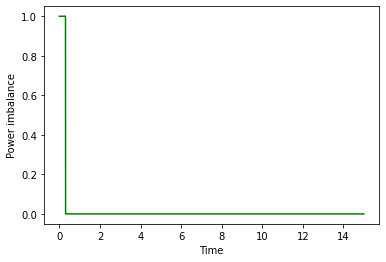

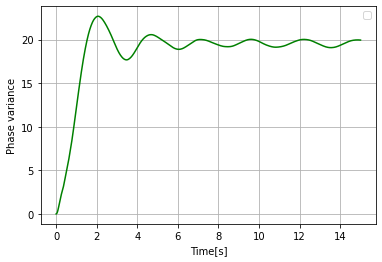

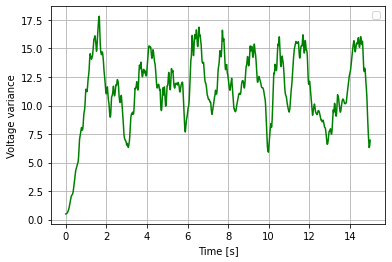

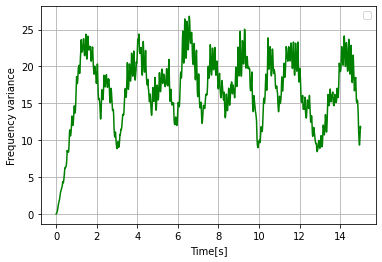

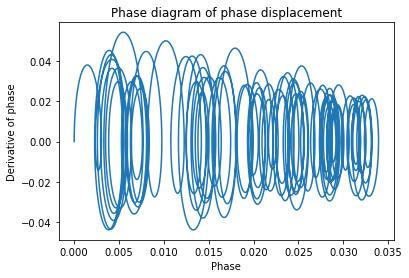

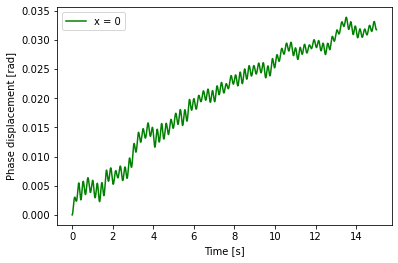

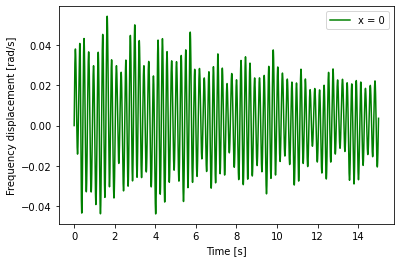

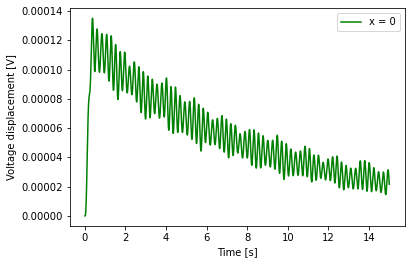

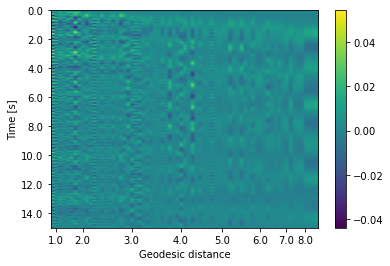

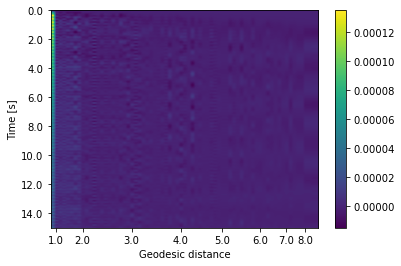

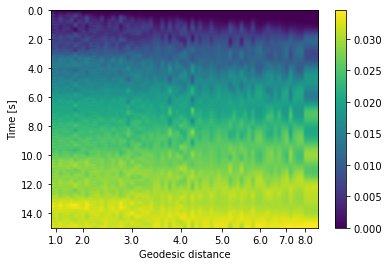

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import networkx as nx

# Obtain the geodesic distances
def grid_var(Adj_matrix, x_P):
    G = nx.from_numpy_matrix(Adj_matrix)
    p = nx.shortest_path(G)
    g_dist = np.zeros(np.shape(Adj_matrix)[0])
    
    i = 0
    while i < (np.shape(Adj_matrix)[0]):
        j = 0
        while j < len(p[x_P][i]):
            g_dist[p[x_P][i][j]] = j
            j = j + 1
            
        i = i + 1
    return g_dist**2

########################
# Phase coefficients
H = 1 # Scaling coefficient (representing inertia like behaviour)

g1 = 0.1 # Damping coefficient
v1 = 100.5 # velocity squared

g = g1/H # Damping coefficient
v = v1/H # velocity squared

# Vo.ltage coefficients
T = 8.39
W = 0.11
F = 0.34

# Import the adjecency matrix 

A = np.load(r"C:/Users/Fahrudin Delic/Desktop/nglines_Adj_matrix.npy")

#A = np.load(r"C:/Users/Fahrudin Delic/Desktop/Test matrix.npy")

# Position of the initial power inbalance
x_P = 23

# Grid points
dx = 1

# Time steps
dt = 0.001
# Time iteratios
tmax = 15

# Dirac delta power for the ramp function
P0 = 1

t_ramp = 0.3 # End of ramp function
t0_ramp = 0 # Start of ramp function 

# Initial phase and first derivative of phase 
y00 = 0
yi00 = 0
V00 = 0
Vi00 = 0



#####################

# Calculate necessary constants

Dw = W/T # Diffusion constat
tau1 = 1/(g - 1/T + (2*W)/T) # tau prime

print("Diffusion coefficient Dw:", Dw)
print("Tau1:" , tau1)
#print("Critical time Dw/v^2: ", Dw/v )
print("Critical time tc = 0.01 * tau1: ", 0.001 * tau1)

start = time.time()

# Create necessary arrays

# Create the spatial coordinates of Nigerian grid
x = np.linspace(0,int(np.shape(A)[0] - 1), int(np.shape(A)[0]))

# Phase RK coefficients
ay1 = 0 * x # k1, 1st component
ay2 = 0 * x # k1, 2nd component
by1 = 0 * x # k2, 1st component
by2 = 0 * x # k2, 2nd component of vector
cy1 = 0 * x # k3, 1st component
cy2 = 0 * x # k3, 2nd component
dy1 = 0 * x # k4, 1st component
dy2 = 0 * x # k4, 2nd component

# Voltage RK coefficients
av1 = 0 * x
bv1 = 0 * x 
cv1 = 0 * x
dv1 = 0 * x


y = np.zeros(((int(tmax/dt + 2)), int(np.shape(A)[0])))
yi = np.zeros(((int(tmax/dt + 2)),int(np.shape(A)[0])))
V = np.zeros(((int(tmax/dt + 2)), int(np.shape(A)[0])))
P0_array = np.zeros(((int(tmax/dt + 2)), int(np.shape(A)[0])))


# Initial conditions of y(if necessary)
y[0, x_P] = y00
yi[0, x_P] = yi00
V[0, x_P] = V00


# Initial condition of initial power disturbance

while t0_ramp < (t_ramp):
    P0_array[int(t0_ramp/dt), x_P] = P0
    t0_ramp = t0_ramp + dt

# Create necessary arrays for time, and spatial plottings 
t = 0
tarray = []
var_array_y = []
var_array_V = []
var_array_yi = []
qarray = []

# Get the grid coefficients
var_coef = grid_var(A, x_P)

q = 0 # Counter of time steps
# Run the program until the tmax
while t <= tmax:
    tarray += [t]
    qarray +=[q]
    # Variance of phase
    var_y_n = np.sum(var_coef * y[q,:])/np.sum(y[q,:])
    var_array_y += [float(var_y_n)] # Update phase varience array
    # Frequency variance
    var_yi_n = np.sum(var_coef * np.abs(yi[q,:]))/(np.sum(np.abs(yi[q,:])))
    var_array_yi += [float(var_yi_n)] # Update frequency varience array
    # Voltage variance
    var_V_n = np.sum((var_coef * np.abs(V[q,:])))/(np.sum(np.abs(V[q,:])))
    var_array_V += [float(var_V_n)] # Update voltage varience array
    i = 0
    while i < (len(x)):
        ay1[i] = dt * yi[q,i]
        ay2[i] = dt * (-g * yi[q, i] - v * (np.sum(A[i,:] * (y[q,i] - y[q,:]))) + P0_array[q, i] )
        av1[i] = (dt/T) * (-V[q, i] + W * (np.sum(A[i,:] * V[q,:])) + F * (np.sum(A[i,:] * (y[q,i] - y[q,:]))) )
        i = i + 1
    i = 0
    while i < (len(x)):
        by1[i] = dt * (yi[q, i] + 0.5 * ay2[i])
        by2[i] = dt * (-g * (yi[q, i] + 0.5 * ay2[i]) - v * (np.sum(A[i,:] * ((y[q,i] + 0.5 * ay1[i]) - (y[q,:] + 0.5 * ay1))))  + P0_array[q, i])
        bv1[i] = (dt/T) * (-1*(V[q, i] + 0.5 * av1[i]) + W * (np.sum(A[i,:] * (V[q,:] + 0.5 * av1))) + F * (np.sum(A[i,:] * ((y[q,i] + 0.5 * ay1[i]) - (y[q,:] + 0.5 * ay1)))))
        i = i + 1
    i = 0
    while i < (len(x)):
        cy1[i] = dt * (yi[q, i] + 0.5 * by2[i])
        cy2[i] = dt * (-g * (yi[q, i] + 0.5 * by2[i]) - v * (np.sum(A[i,:] * ((y[q,i] + 0.5 * by1[i]) - (y[q,:] + 0.5 * by1)))) + P0_array[q, i])
        cv1[i] = (dt/T) * (-1*(V[q, i] + 0.5 * bv1[i]) + W * (np.sum(A[i,:] * (V[q,:] + 0.5 * bv1)))  + F * (np.sum(A[i,:] * ((y[q,i] + 0.5 * by1[i]) - (y[q,:] + 0.5 * by1)))))
        i = i + 1
    i = 0
    while i < (len(x)):
        dy1[i] = dt * (yi[q, i] + cy2[i])
        dy2[i] = dt * (-g * (yi[q, i] + cy2[i]) - v * (np.sum(A[i,:] * ((y[q,i] + cy1[i]) - (y[q,:] + cy1)))) + P0_array[q, i])
        dv1[i] = (dt/T) * (-1*(V[q, i] + cv1[i]) + W * (np.sum(A[i,:] * (V[q,:] + cv1)))  + F * (np.sum(A[i,:] * ((y[q,i] + cy1[i]) - (y[q,:] + cy1)))))
        i = i + 1
    i = 0
    while i < (len(x)):
        # Update the phases
        y[q+1, i] = y[q, i] + (1/6) * (ay1[i] + 2 * by1[i] + 2 * cy1[i] + dy1[i])
        yi[q+1, i] = yi[q, i] + (1/6) * (ay2[i] + 2 * by2[i] + 2 * cy2[i] + dy2[i])
        V[q+1,i] = V[q,i] + (1/6) * (av1[i] + 2 * bv1[i] + 2 * cv1[i] + dv1[i])
        i = i + 1
    t = t + dt
    timet = time.time()
    q = q + 1

# Update the last t and variance arrays
tarray += [float(t + dt)] # Update the last iteration
qarray += [q + 1]


# Variance of phase
var_y_n = np.sum(var_coef * y[q,:])/np.sum(y[q,:])
var_array_y += [float(var_y_n)] # Update phase varience array
# Frequency variance
var_yi_n = np.sum((var_coef * np.abs(yi[q,:])))/(np.sum(np.abs(yi[q,:])))
var_array_yi += [float(var_yi_n)] # Update frequency varience array
# Voltage variance
var_V_n = np.sum((var_coef * np.abs(V[q,:])))/(np.sum(np.abs(V[q,:])))
var_array_V += [float(var_V_n)] # Update voltage varience array
    
end = time.time()



print("Execution time:", end-start)

# Saving the data

np.save("Phase 1D.npy", y)
np.save("Frequency 1D.npy", yi)
np.save("Voltage 1D.npy", V)


fig4 = plt.figure()
plt.plot(tarray, P0_array[:, int(x_P)], "g", )
plt.xlabel("Time")
plt.ylabel("Power imbalance")
plt.savefig("Power imbalance", dpi = 350)


fig7 = plt.figure()
#plt.title("Phase petrubation variance")
plt.plot(tarray, var_array_y, "g")
#plt.plot(tarray, var_y_anal, "r", label = "Analytical result of phase variance")
plt.xlabel("Time[s]")
plt.ylabel("Phase variance")
plt.legend()
plt.grid()
plt.savefig("Phase variance", dpi = 350)


fig8 = plt.figure()
#plt.title("Voltage petrubation variance")
plt.plot(tarray, var_array_V, "g")
#plt.plot(tarray, var_V_anal, "r", label = "Analytical result of voltage variance")
plt.xlabel("Time [s]")
plt.ylabel("Voltage variance")
plt.legend()
plt.grid()
plt.savefig("Voltage variance ", dpi = 350)


#var_yi_anal = 1/3 * np.array(tarray)**2 * v # Analytical result for variance of frequency

fig9 = plt.figure()
#plt.title("Frequency variance")
plt.plot(tarray, var_array_yi, "g")
#plt.plot(tarray, var_yi_anal, "r", label = "Analytical result of frequency variance")
plt.xlabel("Time[s]")
plt.ylabel("Frequency variance")
plt.legend()
plt.grid()
plt.savefig("Frequency variance ", dpi = 350)


fig10 = plt.figure()
plt.title("Phase diagram of phase displacement")
plt.plot(y[:, int(x_P)], yi[:, int(x_P)])
plt.xlabel("Phase")
plt.ylabel("Derivative of phase")
plt.savefig("Phase diagram ", dpi = 350)


# Rearrange the arrays with geometric distance
geom_dist = grid_var(A, x_P)**(1/2) # Get the geodesic distance
sort_array = np.argsort(geom_dist) # Get the indicies for sorting

# Create sorting arrays
x_len = np.shape(y)[1]
y_len = np.shape(y)[0]

y_sort = np.zeros((y_len,x_len))
yi_sort = np.zeros((y_len,x_len))
V_sort = np.zeros((y_len,x_len))
d_sort = np.zeros(x_len)

# Sort the arrays

i1 = 0
while i1 < x_len:
    y_sort[:,i1] = y[:,sort_array[i1]]
    yi_sort[:,i1] = yi[:,sort_array[i1]]
    V_sort[:,i1] = V[:, sort_array[i1]]
    d_sort[i1] = int(geom_dist[sort_array[i1]])
    i1 = i1 + 1
    

x_sample = np.array([x[1], x[8], x[21], x[34], x[45], x[55], x[62], x[67]])
d_sample = np.array([d_sort[1], d_sort[8], d_sort[21], d_sort[34], d_sort[45], d_sort[55], d_sort[62], d_sort[67]])
    

tp = 2 # Plotting seconds
tpq = int(tp/dt)
tarray1 = np.round(np.array(tarray[0::tpq]),2)

fig5 = plt.figure()
#plt.title("Phase displacement at node i")
plt.plot(tarray, y[:, int(x_P)], "g", label = "x = 0")
#plt.plot(tarray, y[:, int(x_P + 10 )], "b--", label = "x = 1")
#plt.plot(tarray, y[:, int(x_P + 20 )], "r", label = "x = 20")
plt.xlabel("Time [s]")
plt.ylabel("Phase displacement [rad]")
plt.legend()
plt.savefig("Phase displacement ", dpi = 350)

fig51 = plt.figure()
#plt.title("Frequency at node i")
plt.plot(tarray, yi[:, int(x_P)], "g", label = "x = 0")
#plt.plot(tarray, yi[:, int(x_P + 10 )], "b--", label = "x = 1")
#plt.plot(tarray, yi[:, int(x_P + 20 )], "r--", label = "x = 20")
plt.xlabel("Time [s]")
plt.ylabel("Frequency displacement [rad/s]")
plt.legend()
plt.savefig("Frequency displacement", dpi = 350)

fig6 = plt.figure()
#plt.title("Voltage displacement at node i")
plt.plot(tarray, V[:, int(x_P)], "g", label = "x = 0")
#plt.plot(tarray, V[:, int(x_P + 10 )], "b--", label = "x = 1")
#plt.plot(tarray, V[:, int(x_P + 20 )], "r--", label = "x = 20")
plt.xlabel("Time [s]")
plt.ylabel("Voltage displacement [V]")
plt.legend()
plt.savefig("Voltage displacement ", dpi = 350)


fig11 = plt.figure()
plt.imshow(yi_sort, aspect = "auto")
plt.xticks(x_sample, d_sample)
plt.yticks(qarray[0::tpq], tarray1)
#plt.title("Frequency heat map")
plt.xlabel("Geodesic distance")
plt.ylabel("Time [s]")
plt.colorbar()
plt.savefig("Frequency graph", dpi = 350)

fig12 = plt.figure()
plt.imshow(V_sort, aspect = "auto")
plt.xticks(x_sample, d_sample)
plt.yticks(qarray[0::tpq], tarray1)
#plt.title("Voltage heat map")
plt.xlabel("Geodesic distance")
plt.ylabel("Time [s]")
plt.colorbar()
plt.savefig("Voltage petrubation heat map", dpi = 350)

fig13 = plt.figure()
plt.imshow(y_sort, aspect = "auto")
plt.xticks(x_sample, d_sample)
plt.yticks(qarray[0::tpq], tarray1)
#plt.title("Phase heat map")
plt.xlabel("Geodesic distance")
plt.ylabel("Time [s]")
plt.colorbar()
plt.savefig("Phase petrubation heat map", dpi = 350)